In [80]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from xgboost.sklearn import XGBClassifier

In [81]:
data = pd.read_csv('ds_novo/dataset_treino.csv', na_filter=False)
test = pd.read_csv("ds_novo/dataset_teste.csv", na_filter=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Columns: 362 entries, ID to Transition
dtypes: float64(350), int64(11), object(1)
memory usage: 862.7+ KB


In [82]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 361 entries, ID to Age
dtypes: float64(348), int64(13)
memory usage: 282.2 KB


In [83]:
# 2. Processar o conjunto de treino
# Separar X (características) e y (alvo)
X = data.drop(columns=["Transition", "ID"])  # Remover a coluna-alvo e "ID"
y = data["Transition"]

In [84]:
X = X.select_dtypes(include=['number'])  # Apenas colunas numéricas
test_filtered = test.select_dtypes(include=['number'])  # Apenas colunas numéricas no teste


In [85]:
# Normalizar os dados
scaler = StandardScaler()
X = scaler.fit_transform(X)  # Ajustar e transformar os dados de treino
# Verifique se a coluna "ID" existe antes de tentar removê-la
if "ID" in test_filtered.columns:
    X_test = scaler.transform(test_filtered.drop(columns=["ID"]))  # Transformar os dados de teste sem "ID"
else:
    X_test = scaler.transform(test_filtered)  # Apenas transforme os dados


In [86]:
# Dividir em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

print("Treino:", X_train.shape, y_train.shape)
print("Teste:", X_val.shape, y_val.shape)

Treino: (213, 360) (213,)
Teste: (92, 360) (92,)


Decision Tree

In [93]:
dt_model = DecisionTreeClassifier(max_depth=2, random_state=2022)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=2022)

In [94]:
from sklearn.metrics import accuracy_score, f1_score
dt_predictions = dt_model.predict(X_val)

# Calcular métricas
dt_accuracy = accuracy_score(y_val, dt_predictions)
dt_f1_macro = f1_score(y_val, dt_predictions, average='macro')
dt_f1_weighted = f1_score(y_val, dt_predictions, average='weighted')

# Armazenar as métricas no dicionário
results = {
    'DT': {
        'Accuracy': dt_accuracy,
        'F1 Macro': dt_f1_macro,
        'F1 Weighted': dt_f1_weighted
    }
}

In [95]:
print(classification_report(y_val, dt_predictions))

              precision    recall  f1-score   support

       AD-AD       0.50      0.31      0.38        13
       CN-CN       0.53      0.43      0.47        21
      MCI-AD       0.44      0.64      0.52        11
     MCI-MCI       0.25      0.31      0.28        16

    accuracy                           0.41        61
   macro avg       0.43      0.42      0.41        61
weighted avg       0.43      0.41      0.41        61



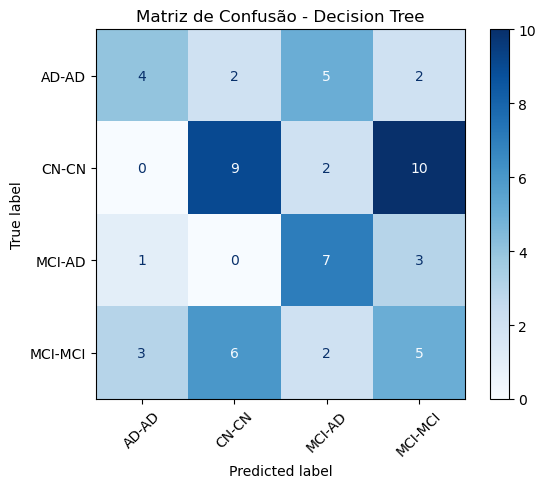

In [96]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = sorted(set(y_val))  # Garante que apenas as classes presentes no y_val sejam usadas
cm = confusion_matrix(y_val, dt_predictions, labels=labels)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
cmd.plot(cmap='Blues', xticks_rotation=45)

# Adicionar título
plt.title('Matriz de Confusão - Decision Tree')
plt.show()

Nas linhas vemos os valores reais.
Nas colunas vemos as previsões feitas.
O número nas celulas indica a quantidade de vezes que foi previsto.

Na diagonal estão os acertados, valores fora da diagonal foram previstos erradamente.

SVM

In [97]:
svm_model = SVC(random_state=2022)
svm_model.fit(X_train, y_train)

SVC(random_state=2022)

In [98]:
svm_predictions = svm_model.predict(X_val)

# Calcular métricas
svm_accuracy = accuracy_score(y_val, svm_predictions)
svm_f1_macro = f1_score(y_val, svm_predictions, average='macro')
svm_f1_weighted = f1_score(y_val, svm_predictions, average='weighted')

# Armazenar as métricas no dicionário
results['SVM'] = {
    'Accuracy': svm_accuracy,
    'F1 Macro': svm_f1_macro,
    'F1 Weighted': svm_f1_weighted
}

In [99]:
print(classification_report(y_val, svm_predictions))

              precision    recall  f1-score   support

       AD-AD       0.55      0.46      0.50        13
       CN-CN       0.52      0.76      0.62        21
      MCI-AD       0.33      0.36      0.35        11
     MCI-MCI       0.43      0.19      0.26        16

    accuracy                           0.48        61
   macro avg       0.46      0.44      0.43        61
weighted avg       0.47      0.48      0.45        61



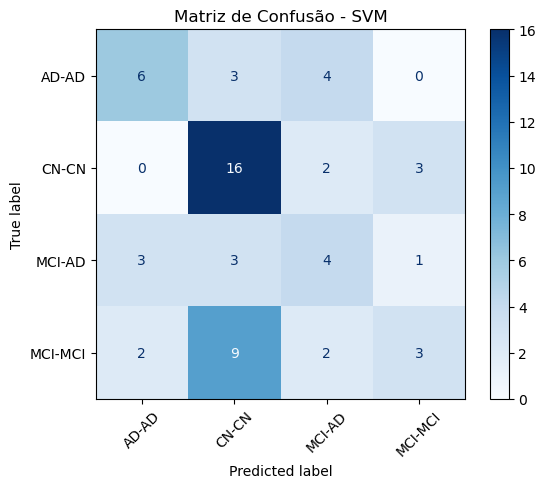

In [100]:
# Obter as classes presentes no conjunto de validação
labels = sorted(set(y_val))  # Classes reais presentes no y_val

# Criar a matriz de confusão
cm = confusion_matrix(y_val, svm_predictions, labels=labels)

# Exibir a matriz de confusão
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
cmd.plot(cmap='Blues', xticks_rotation=45)

# Adicionar título
plt.title('Matriz de Confusão - SVM')
plt.show()

Random Forest

In [101]:
rf_model = RandomForestClassifier(bootstrap= False, max_depth = 2, verbose=1)
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


RandomForestClassifier(bootstrap=False, max_depth=2, verbose=1)

In [102]:
# Fazer previsões
rf_predictions = rf_model.predict(X_val)

# Calcular métricas
rf_accuracy = accuracy_score(y_val, rf_predictions)
rf_f1_macro = f1_score(y_val, rf_predictions, average='macro')
rf_f1_weighted = f1_score(y_val, rf_predictions, average='weighted')

# Armazenar as métricas no dicionário
results['RF'] = {
    'Accuracy': rf_accuracy,
    'F1 Macro': rf_f1_macro,
    'F1 Weighted': rf_f1_weighted
}

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [103]:
print(classification_report(y_val, rf_predictions))

              precision    recall  f1-score   support

       AD-AD       0.50      0.46      0.48        13
       CN-CN       0.50      0.81      0.62        21
      MCI-AD       0.27      0.36      0.31        11
     MCI-MCI       0.00      0.00      0.00        16

    accuracy                           0.44        61
   macro avg       0.32      0.41      0.35        61
weighted avg       0.33      0.44      0.37        61



c:\Users\rafaa\miniconda3\envs\mypython3version\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rafaa\miniconda3\envs\mypython3version\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rafaa\miniconda3\envs\mypython3version\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

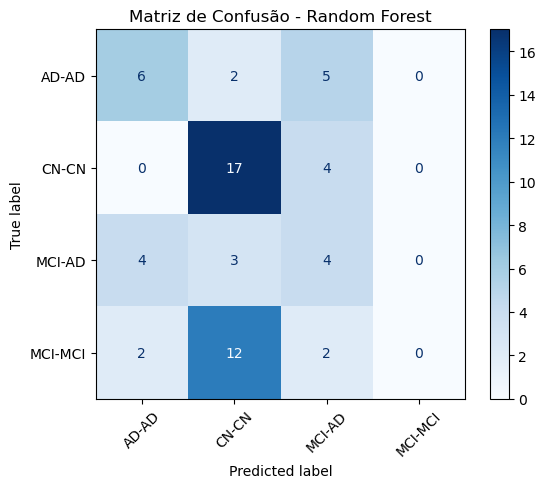

In [104]:
# Garantir que os rótulos de classes correspondam ao y_val
labels = sorted(set(y_val))  # Classes presentes no conjunto de validação

# Criar a matriz de confusão
cm = confusion_matrix(y_val, rf_predictions, labels=labels)

# Exibir a matriz de confusão
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
cmd.plot(cmap='Blues', xticks_rotation=45)

# Adicionar título
plt.title('Matriz de Confusão - Random Forest')
plt.show()

BAGGING

In [105]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=20, random_state=2022)

In [106]:
bg_model = BaggingClassifier(estimator=dt_model, bootstrap=True)
n_estimators = [10,40,60,80,100,160]
parameters = {'n_estimators': n_estimators}
grid_bg = GridSearchCV(estimator=bg_model, param_grid=parameters, cv=sss)
grid_bg.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=2022, test_size=20,
            train_size=None),
             estimator=BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                                          random_state=2022)),
             param_grid={'n_estimators': [10, 40, 60, 80, 100, 160]})

In [107]:
best_bg_model = grid_bg.best_estimator_
print(best_bg_model)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                   random_state=2022),
                  n_estimators=80)


In [108]:
best_bg_model.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                   random_state=2022),
                  n_estimators=80)

In [109]:
# Fazer previsões
best_bg_predictions = best_bg_model.predict(X_val)

# Calcular métricas
best_bg_accuracy = accuracy_score(y_val, best_bg_predictions)
best_bg_f1_macro = f1_score(y_val, best_bg_predictions, average='macro')
best_bg_f1_weighted = f1_score(y_val, best_bg_predictions, average='weighted')

# Armazenar as métricas no dicionário
results['Bagg'] = {
    'Accuracy': best_bg_accuracy,
    'F1 Macro': best_bg_f1_macro,
    'F1 Weighted': best_bg_f1_weighted
}

In [110]:
print(classification_report(y_val, best_bg_predictions))

              precision    recall  f1-score   support

       AD-AD       0.50      0.46      0.48        13
       CN-CN       0.55      0.76      0.64        21
      MCI-AD       0.36      0.45      0.40        11
     MCI-MCI       0.33      0.12      0.18        16

    accuracy                           0.48        61
   macro avg       0.44      0.45      0.43        61
weighted avg       0.45      0.48      0.44        61



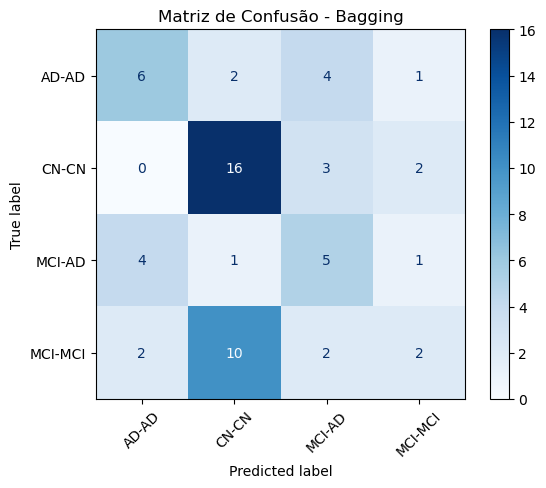

In [111]:
# Criar a matriz de confusão
labels = sorted(set(y_val))  # Garantir consistência com y_val
cm = confusion_matrix(y_val, best_bg_predictions, labels=labels)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
cmd.plot(cmap='Blues', xticks_rotation=45)

# Adicionar título
plt.title('Matriz de Confusão - Bagging')
plt.show()

Gradient BOOSTING

In [112]:
gbc_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=2022)
gbc_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=2022)

In [113]:
# Fazer previsões
gbc_predictions = gbc_model.predict(X_val)

# Calcular métricas
gbc_accuracy = accuracy_score(y_val, gbc_predictions)
gbc_f1_macro = f1_score(y_val, gbc_predictions, average='macro')
gbc_f1_weighted = f1_score(y_val, gbc_predictions, average='weighted')

# Armazenar as métricas no dicionário
results['GB'] = {
    'Accuracy': gbc_accuracy,
    'F1 Macro': gbc_f1_macro,
    'F1 Weighted': gbc_f1_weighted
}

In [114]:
print(classification_report(y_val, gbc_predictions))

              precision    recall  f1-score   support

       AD-AD       0.40      0.46      0.43        13
       CN-CN       0.57      0.62      0.59        21
      CN-MCI       0.00      0.00      0.00         0
      MCI-AD       0.17      0.18      0.17        11
     MCI-MCI       0.50      0.25      0.33        16

    accuracy                           0.41        61
   macro avg       0.33      0.30      0.31        61
weighted avg       0.44      0.41      0.41        61



c:\Users\rafaa\miniconda3\envs\mypython3version\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rafaa\miniconda3\envs\mypython3version\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rafaa\miniconda3\envs\mypython3version\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

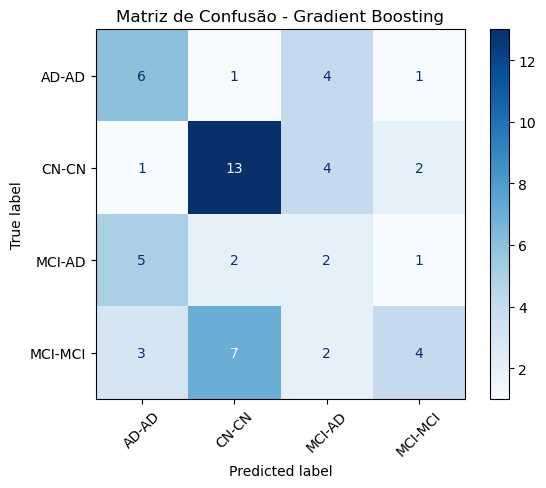

In [115]:
# Obter os rótulos das classes presentes no conjunto de validação
labels = sorted(set(y_val))  # Garantir consistência com y_val

# Criar a matriz de confusão
cm = confusion_matrix(y_val, gbc_predictions, labels=labels)

# Exibir a matriz de confusão
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
cmd.plot(cmap='Blues', xticks_rotation=45)

# Adicionar título
plt.title('Matriz de Confusão - Gradient Boosting')
plt.show()


XGBoost

In [116]:
from sklearn.preprocessing import LabelEncoder

# Codificar os rótulos
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

In [117]:
xgb_model = XGBClassifier(max_depth=1, objective = 'reg:squarederror')
xgb_model.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [118]:
xgb_predictions_encoded = xgb_model.predict(X_val)
xgb_predictions = label_encoder.inverse_transform(xgb_predictions_encoded)

# Calcular métricas
xgb_accuracy = accuracy_score(y_val, xgb_predictions)
xgb_f1_macro = f1_score(y_val, xgb_predictions, average='macro')
xgb_f1_weighted = f1_score(y_val, xgb_predictions, average='weighted')

# Armazenar as métricas no dicionário
results['XGB'] = {
    'Accuracy': xgb_accuracy,
    'F1 Macro': xgb_f1_macro,
    'F1 Weighted': xgb_f1_weighted
}

In [119]:
print(classification_report(y_val, xgb_predictions))

              precision    recall  f1-score   support

       AD-AD       0.42      0.38      0.40        13
       CN-CN       0.61      0.67      0.64        21
      MCI-AD       0.14      0.18      0.16        11
     MCI-MCI       0.50      0.38      0.43        16

    accuracy                           0.44        61
   macro avg       0.42      0.40      0.41        61
weighted avg       0.46      0.44      0.45        61



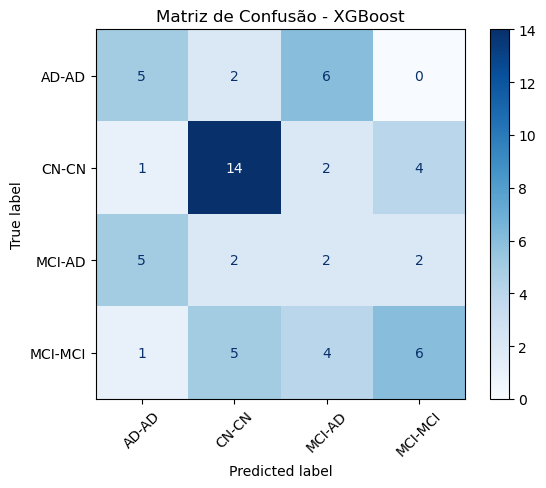

In [120]:
# Obter os rótulos das classes presentes no conjunto de validação
labels = sorted(set(y_val))  # Garantir consistência com y_val

# Criar a matriz de confusão
cm = confusion_matrix(y_val, xgb_predictions, labels=labels)

# Exibir a matriz de confusão
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
cmd.plot(cmap='Blues', xticks_rotation=45)

# Adicionar título
plt.title('Matriz de Confusão - XGBoost')
plt.show()

STACKING

In [121]:
estimators = [("dt", dt_model), ("svm", svm_model), ("rf", rf_model)]
st_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [122]:
st_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
c:\Users\rafaa\miniconda3\envs\mypython3version\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/p

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(max_depth=2,
                                                       random_state=2022)),
                               ('svm', SVC(random_state=2022)),
                               ('rf',
                                RandomForestClassifier(bootstrap=False,
                                                       max_depth=2,
                                                       verbose=1))],
                   final_estimator=LogisticRegression())

In [123]:
# Fazer previsões
st_predictions = st_model.predict(X_val)

# Calcular métricas
st_accuracy = accuracy_score(y_val, st_predictions)
st_f1_macro = f1_score(y_val, st_predictions, average='macro')
st_f1_weighted = f1_score(y_val, st_predictions, average='weighted')

# Armazenar as métricas no dicionário
results['Stack'] = {
    'Accuracy': st_accuracy,
    'F1 Macro': st_f1_macro,
    'F1 Weighted': st_f1_weighted
}

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [124]:
print(classification_report(y_val, st_predictions))

              precision    recall  f1-score   support

       AD-AD       0.46      0.46      0.46        13
       CN-CN       0.56      0.86      0.68        21
      MCI-AD       0.09      0.09      0.09        11
     MCI-MCI       0.00      0.00      0.00        16

    accuracy                           0.41        61
   macro avg       0.28      0.35      0.31        61
weighted avg       0.31      0.41      0.35        61



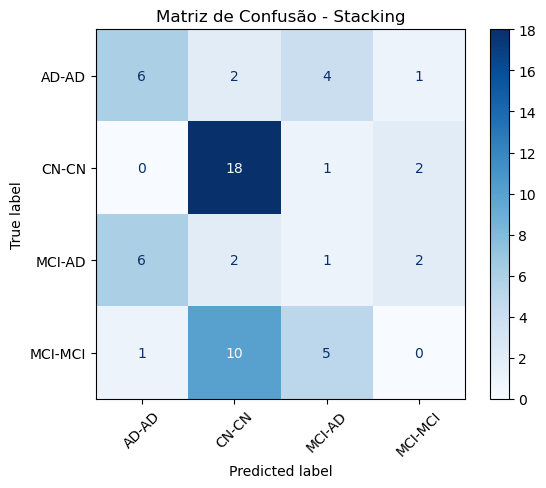

In [125]:
# Obter os rótulos das classes presentes no conjunto de validação
labels = sorted(set(y_val))  # Garantir consistência com y_val

# Criar a matriz de confusão
cm = confusion_matrix(y_val, st_predictions, labels=labels)

# Exibir a matriz de confusão
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
cmd.plot(cmap='Blues', xticks_rotation=45)

# Adicionar título
plt.title('Matriz de Confusão - Stacking')
plt.show()

Max Voting

In [126]:
hvt_model = VotingClassifier(estimators=[("dt", dt_model), ("svm", svm_model), ("rf", rf_model)], voting='hard', weights=[2,1,2])
hvt_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


VotingClassifier(estimators=[('dt',
                              DecisionTreeClassifier(max_depth=2,
                                                     random_state=2022)),
                             ('svm', SVC(random_state=2022)),
                             ('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     max_depth=2, verbose=1))],
                 weights=[2, 1, 2])

In [127]:
for model, label in zip([dt_model, svm_model, rf_model, hvt_model], ['dt', 'svm', 'rf', 'Ensemble']):
    hvt_score = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=5)
    print("Accuracy : %0.2f (+/- %0.2f) [%s]" % (hvt_score.mean(), hvt_score.std(), label))

Accuracy : 0.33 (+/- 0.09) [dt]
Accuracy : 0.43 (+/- 0.07) [svm]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy : 0.46 (+/- 0.04) [rf]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy : 0.39 (+/- 0.06) [Ensemble]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [128]:
# Fazer previsões
hvt_predictions = hvt_model.predict(X_val)

# Calcular métricas
hvt_accuracy = accuracy_score(y_val, hvt_predictions)
hvt_f1_macro = f1_score(y_val, hvt_predictions, average='macro')
hvt_f1_weighted = f1_score(y_val, hvt_predictions, average='weighted')

# Armazenar as métricas no dicionário
results['HVotW'] = {
    'Accuracy': hvt_accuracy,
    'F1 Macro': hvt_f1_macro,
    'F1 Weighted': hvt_f1_weighted
}

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [129]:
print(classification_report(y_val, hvt_predictions))

              precision    recall  f1-score   support

       AD-AD       0.55      0.46      0.50        13
       CN-CN       0.48      0.71      0.58        21
      MCI-AD       0.35      0.55      0.43        11
     MCI-MCI       0.00      0.00      0.00        16

    accuracy                           0.44        61
   macro avg       0.35      0.43      0.38        61
weighted avg       0.35      0.44      0.38        61



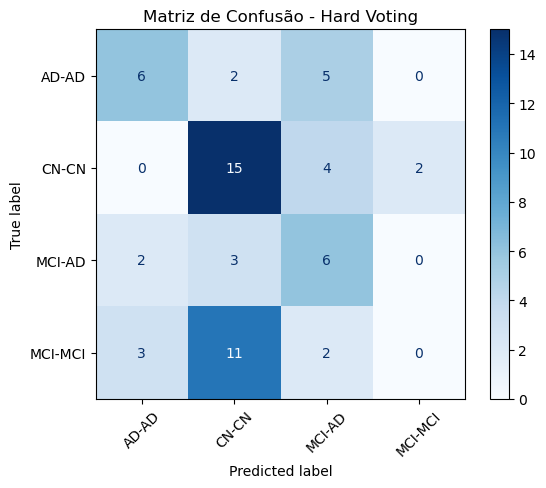

In [130]:
# Criar a matriz de confusão
labels = sorted(set(y_val))
cm = confusion_matrix(y_val, hvt_predictions, labels=labels)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
cmd.plot(cmap='Blues', xticks_rotation=45)

plt.title('Matriz de Confusão - Hard Voting')
plt.show()

Comparação Modelos

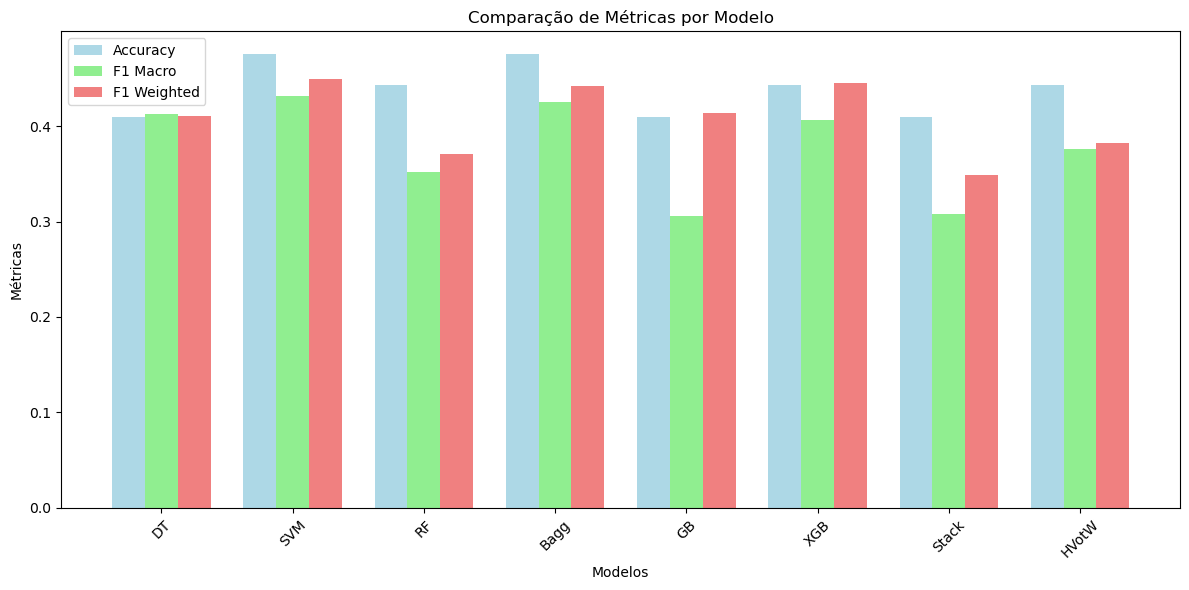

In [131]:
import matplotlib.pyplot as plt
import numpy as np

# Dados para o gráfico
mod = list(results.keys())
metrics = ['Accuracy', 'F1 Macro', 'F1 Weighted']
accuracy = [results[m]['Accuracy'] for m in mod]
f1_macro = [results[m]['F1 Macro'] for m in mod]
f1_weighted = [results[m]['F1 Weighted'] for m in mod]

# Configurar a posição das barras
x = np.arange(len(mod))  # Posições para os modelos
width = 0.25  # Largura de cada barra

# Criar o gráfico
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width, accuracy, width, label='Accuracy', color='lightblue')
bars2 = ax.bar(x, f1_macro, width, label='F1 Macro', color='lightgreen')
bars3 = ax.bar(x + width, f1_weighted, width, label='F1 Weighted', color='lightcoral')

# Adicionar rótulos e título
ax.set_xlabel("Modelos")
ax.set_ylabel("Métricas")
ax.set_title("Comparação de Métricas por Modelo")
ax.set_xticks(x)
ax.set_xticklabels(mod, rotation=45)
ax.legend()

# Ajustar o layout
plt.tight_layout()
plt.show()


In [132]:
print("Comparação:")
print(f"{'Modelo':<10} {'Accuracy':<10} {'F1 Macro':<10} {'F1 Weighted':<10}")
print("-" * 40)
for key, value in results.items():
    print(f"{key:<10} {value['Accuracy']:<10.2f} {value['F1 Macro']:<10.2f} {value['F1 Weighted']:<10.2f}")


Comparação:
Modelo     Accuracy   F1 Macro   F1 Weighted
----------------------------------------
DT         0.41       0.41       0.41      
SVM        0.48       0.43       0.45      
RF         0.44       0.35       0.37      
Bagg       0.48       0.43       0.44      
GB         0.41       0.31       0.41      
XGB        0.44       0.41       0.45      
Stack      0.41       0.31       0.35      
HVotW      0.44       0.38       0.38      


In [133]:
# Calcular a pontuação média de cada modelo
model_scores = {
    model: (metrics['Accuracy'] + metrics['F1 Macro'] + metrics['F1 Weighted']) / 3
    for model, metrics in results.items()
}

# Identificar o melhor modelo
best_model = max(model_scores, key=model_scores.get)
best_score = model_scores[best_model]

# Exibir os resultados
print("Comparação de Modelos (Média das Métricas):")
for model, score in model_scores.items():
    print(f"{model}: Média = {score:.2f}")

print(f"\nMelhor Modelo: {best_model} com pontuação média de {best_score:.2f}")


Comparação de Modelos (Média das Métricas):
DT: Média = 0.41
SVM: Média = 0.45
RF: Média = 0.39
Bagg: Média = 0.45
GB: Média = 0.38
XGB: Média = 0.43
Stack: Média = 0.36
HVotW: Média = 0.40

Melhor Modelo: SVM com pontuação média de 0.45


FICHEIRO SUBMISSÃO

In [134]:
xgb_predictions_encoded = xgb_model.predict(X_test)
test_predictions = label_encoder.inverse_transform(xgb_predictions_encoded)

In [135]:
# 5. Fazer previsões no conjunto de teste
test_predictions = xgb_model.predict(X_test)

In [136]:
# 6. Criar o arquivo de submissão
submission = pd.DataFrame({
    "RowId": test["ID"],  # Utilizar a coluna "ID" do conjunto de teste
    "Result": test_predictions  # Previsões feitas pelo modelo
})

In [137]:
# Salvar o arquivo de submissão
submission.to_csv("dummy_submission.csv", index=False)
print("Arquivo criado com sucesso!")

Arquivo criado com sucesso!
